In [14]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Step 0: Explore the dataset


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1455 entries, 2013-01-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   transactions  1455 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


<Axes: xlabel='date'>

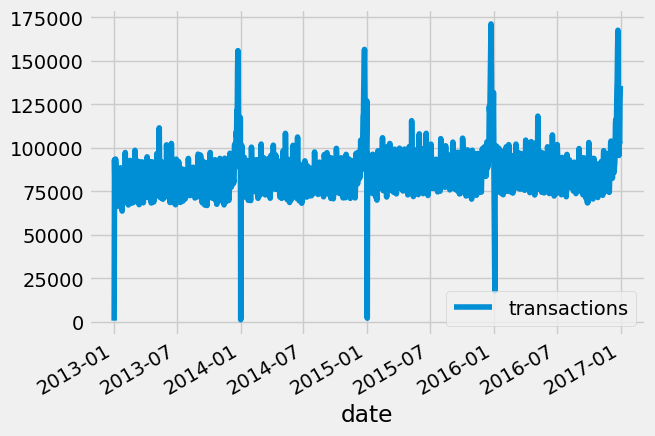

In [15]:
# Load the data files
df = pd.read_csv('train.csv')

df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

df.info()
df.plot()

### Step 1: Check for stationarity of time series

ACF (autocorrelation function) 

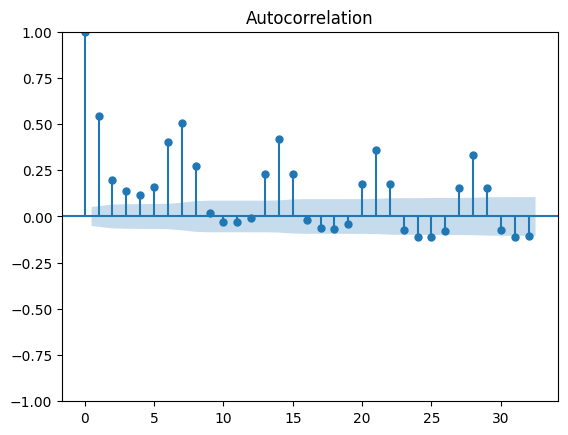

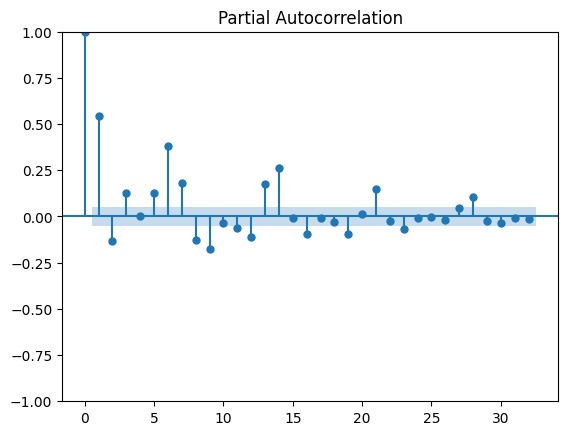

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_orginal = plot_acf(df)
pacf_original = plot_pacf(df)

In [5]:
# ADF test

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df)
print(f'p-value: {adf_test[1]}')

p-value: 9.407649467775781e-05


### Split dataset to train and test

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2013-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2016-01-02 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  363 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='date'>

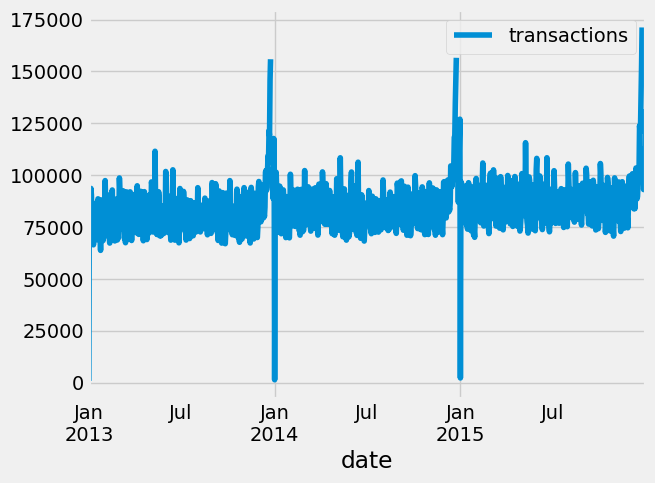

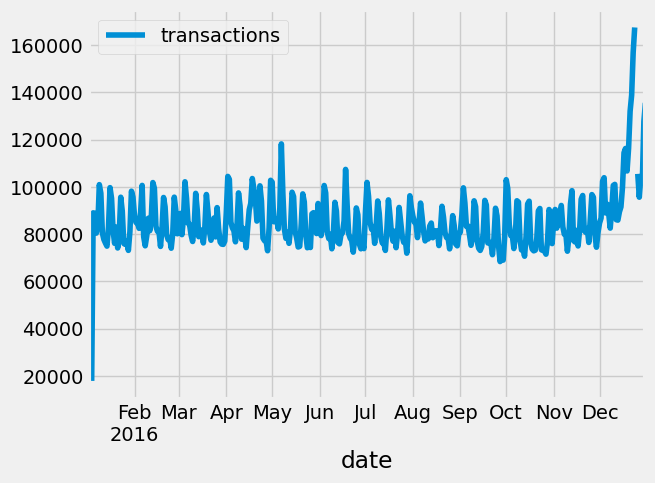

In [16]:
train = df.loc[df.index < '01-01-2016']
train.index = pd.to_datetime(train.index, format='%d-%m-%Y')
train = train.asfreq('D')

test = df.loc[df.index >= '01-01-2016']
test.index = pd.to_datetime(test.index, format='%d-%m-%Y')
test = test.asfreq('D')

train.info()
test.info()

train.plot()
test.plot()

### Step 3: Check train and test datasets

In [7]:
has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

train_interpolated_time = train.interpolate(method='time')
test_interpolated_time = test.interpolate(method='time')

has_nan = train_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = test_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  False
Does the DataFrame have any NaN values?  False


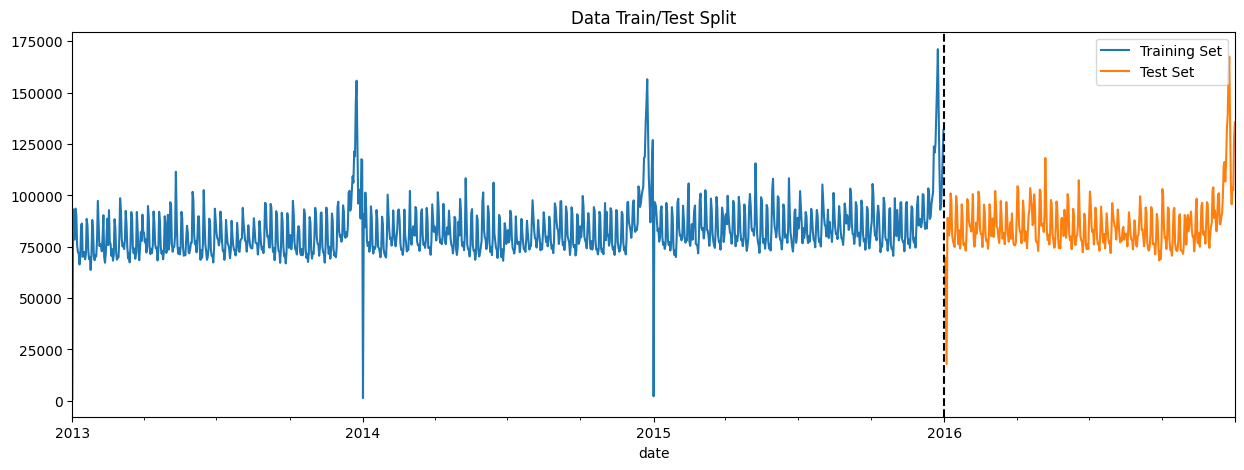

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
train_interpolated_time.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_interpolated_time.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Check how one week looks like

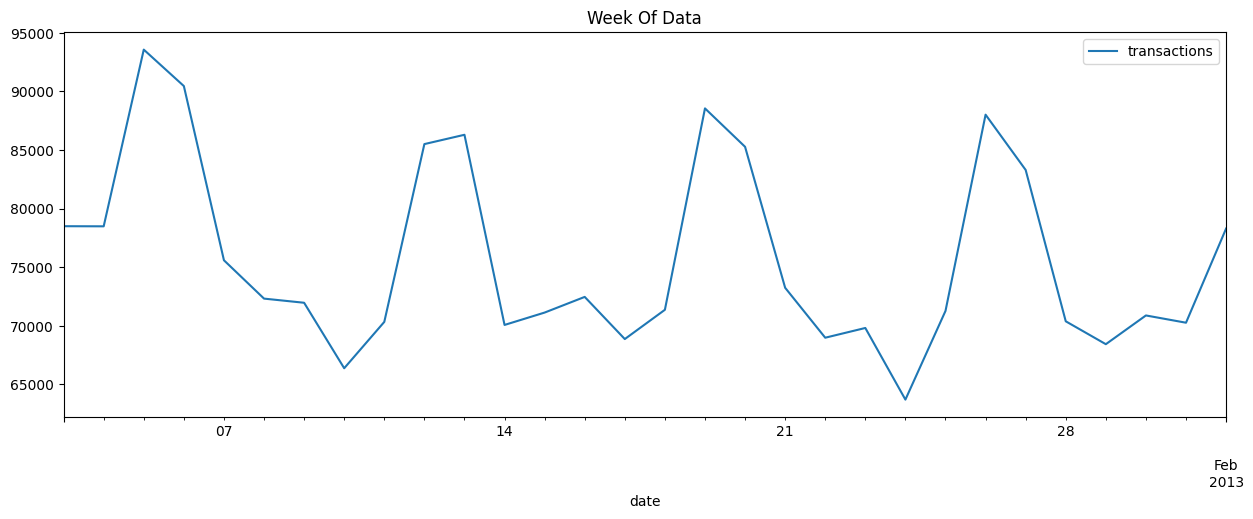

In [10]:
train_interpolated_time.loc[(train_interpolated_time.index > '01-02-2013') & (train_interpolated_time.index < '02-02-2013')].plot(figsize=(15, 5), title='Week Of Data')
plt.show()

### Create time series features based on time series index

            transactions  dayofweek  quarter  month  year  dayofyear  \
date                                                                   
2013-01-01           770          1        1      1  2013          1   
2013-01-02         93215          2        1      1  2013          2   
2013-01-03         78504          3        1      1  2013          3   
2013-01-04         78494          4        1      1  2013          4   
2013-01-05         93573          5        1      1  2013          5   
...                  ...        ...      ...    ...   ...        ...   
2016-12-27         95643          1        4     12  2016        362   
2016-12-28        103717          2        4     12  2016        363   
2016-12-29        102665          3        4     12  2016        364   
2016-12-30        127771          4        4     12  2016        365   
2016-12-31        135568          5        4     12  2016        366   

            dayofmonth  weekofyear  
date                      

C:\Users\ira\AppData\Local\Temp\ipykernel_13984\3215124951.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_with_features, x='month', y='transactions', palette='Blues')


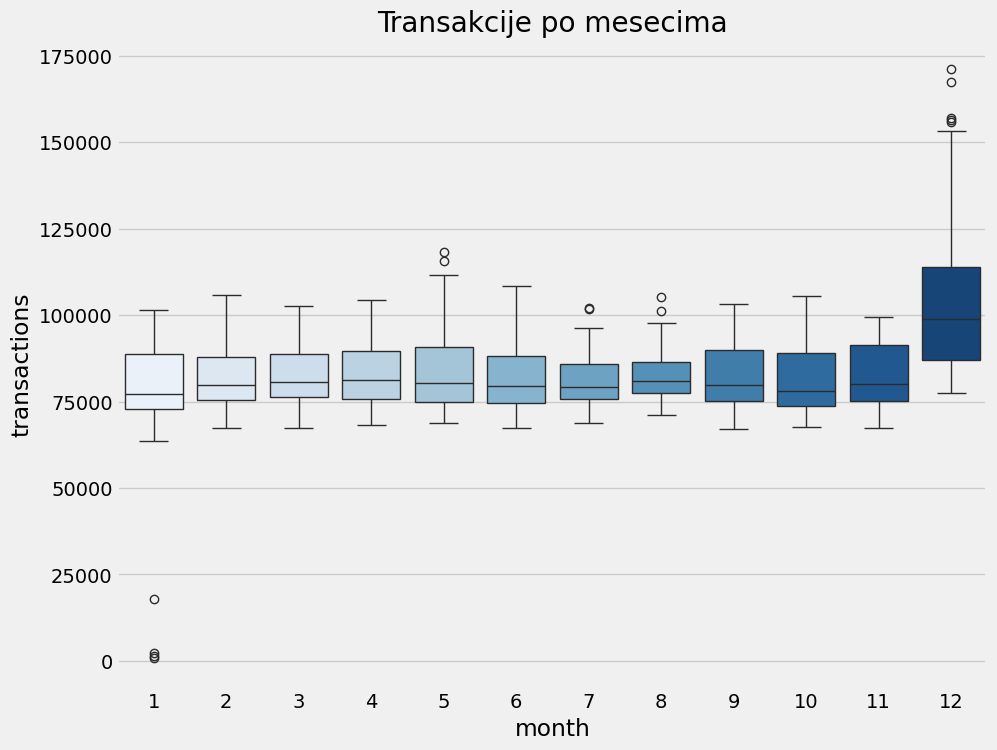

In [19]:
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

def create_features(df):

    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_with_features = create_features(df)
print(df_with_features)

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_with_features, x='month', y='transactions', palette='Blues')
ax.set_title('Transakcije po mesecima')
plt.show()

### Model training

In [31]:

import xgboost as xgb

train_with_features = create_features(train_interpolated_time)
test_with_features = create_features(test_interpolated_time)

print(train_with_features)
print(test_with_features)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'transactions'

X_train = train_with_features[FEATURES]
y_train = train_with_features[TARGET]

X_test = test_with_features[FEATURES]
y_test = test_with_features[TARGET]

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=100, learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

            transactions  dayofweek  quarter  month  year  dayofyear  \
date                                                                   
2013-01-01         770.0          1        1      1  2013          1   
2013-01-02       93215.0          2        1      1  2013          2   
2013-01-03       78504.0          3        1      1  2013          3   
2013-01-04       78494.0          4        1      1  2013          4   
2013-01-05       93573.0          5        1      1  2013          5   
...                  ...        ...      ...    ...   ...        ...   
2015-12-27       93020.0          6        4     12  2015        361   
2015-12-28       95257.0          0        4     12  2015        362   
2015-12-29      104623.0          1        4     12  2015        363   
2015-12-30      118947.0          2        4     12  2015        364   
2015-12-31      131826.0          3        4     12  2015        365   

            dayofmonth  weekofyear  
date                      

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Forecasting

            transactions  dayofweek  quarter  month  year  dayofyear  \
date                                                                   
2016-01-02       69628.0          5        1      1  2016          2   
2016-01-03       43728.5          6        1      1  2016          3   
2016-01-04       17829.0          0        1      1  2016          4   
2016-01-05       89018.0          1        1      1  2016          5   
2016-01-06       88846.0          2        1      1  2016          6   
...                  ...        ...      ...    ...   ...        ...   
2016-12-27       95643.0          1        4     12  2016        362   
2016-12-28      103717.0          2        4     12  2016        363   
2016-12-29      102665.0          3        4     12  2016        364   
2016-12-30      127771.0          4        4     12  2016        365   
2016-12-31      135568.0          5        4     12  2016        366   

            dayofmonth  weekofyear     prediction  
date       

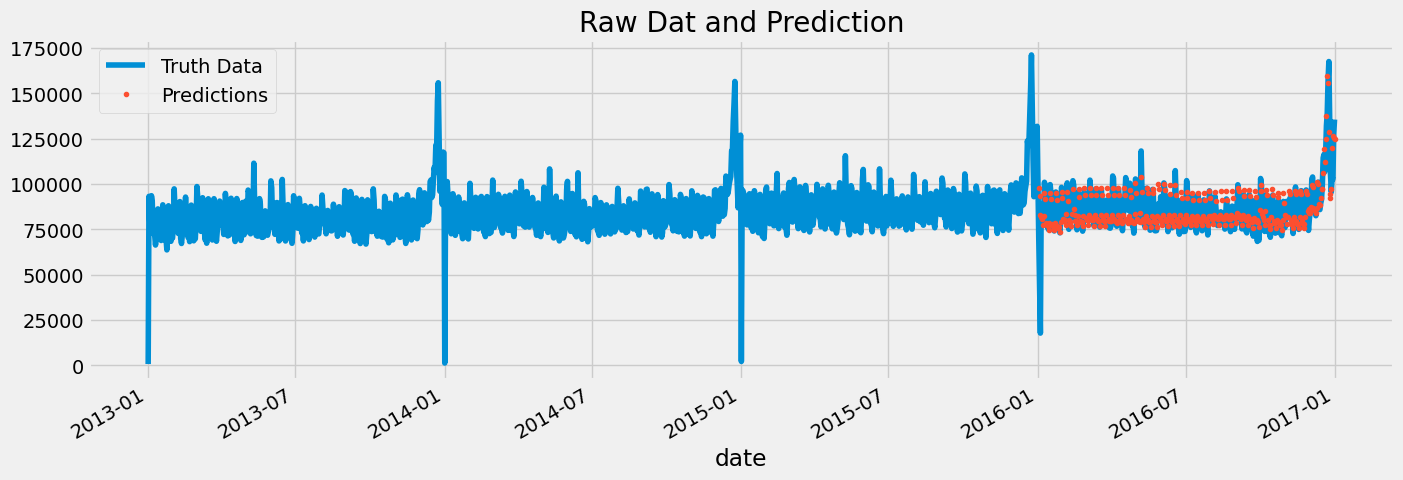

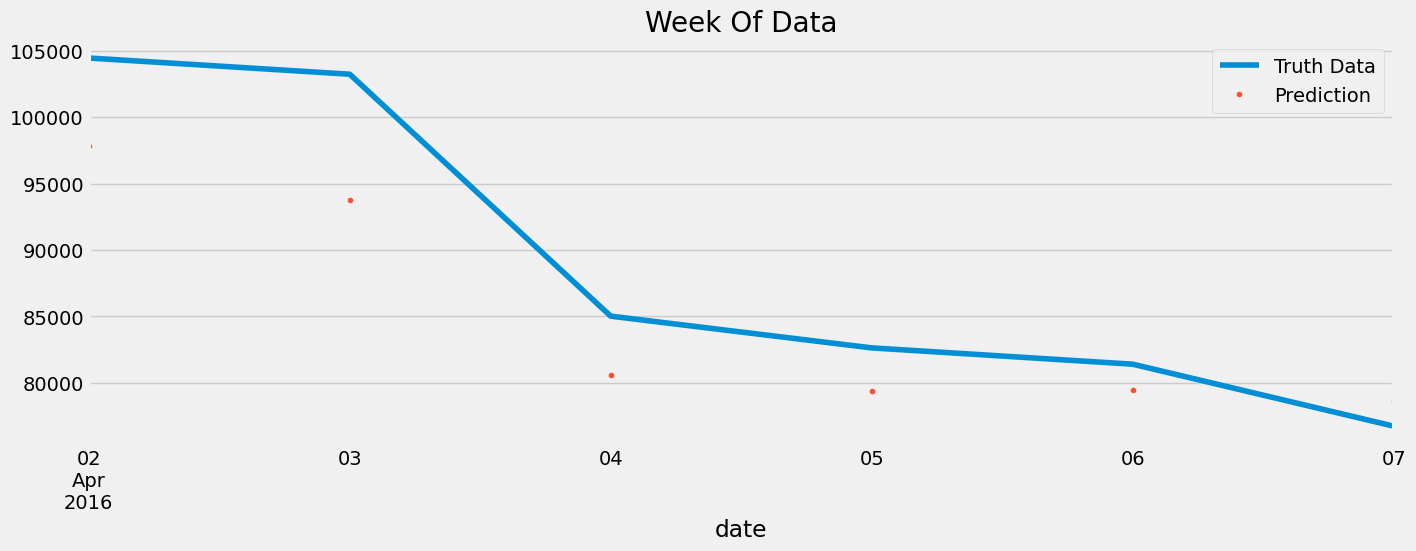

In [32]:
test_with_features['prediction'] = reg.predict(X_test)
print(test_with_features)

ax = df['transactions'].plot(figsize=(15, 5))
test_with_features['prediction'].plot(ax=ax, style='.')
# result['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

#print(test_with_features['transactions'])

ax = test_with_features.loc[(test_with_features.index > '04-01-2016') & (test_with_features.index < '04-08-2016')]['transactions'].plot(figsize=(15, 5), title='Week Of Data')
test_with_features.loc[(test_with_features.index > '04-01-2016') & (test_with_features.index < '04-08-2016')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [33]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

realData = test_with_features.loc[(test_with_features.index > '04-01-2016')]['transactions']
forecastData = test_with_features.loc[(test_with_features.index > '04-01-2016')]['prediction']

mae = mean_absolute_error(realData, forecastData) # koliko su predikcije modela u proseku udaljene od stvarnih vrednosti
mape = mean_absolute_percentage_error(realData, forecastData) # izražava grešku u procentima
rmse = np.sqrt (mean_squared_error(realData, forecastData)) # prosečna kvadratna greška između predikovanih i stvarnih vrednosti
print (f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 4046.580919251825
mape - manual: 0.04510068579282686
rmse - manual: 6282.2098390442525
